In [38]:
import pandas as pd
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

from gensim import corpora, models
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from collections import defaultdict, Counter

from nrclex import NRCLex

print("Libraries imported Successfully!")

Libraries imported Successfully!


## Semantics in Taylor Swift Songs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


like          406
know          380
oh            322
never         294
na            261
love          252
back          240
time          224
got           183
one           179
say           176
see           170
baby          159
wan           158
would         156
could         156
think         153
come          150
go            149
want          142
ever          134
said          127
ca            120
look          116
right         110
take          108
get           107
yeah          103
wish          102
gon           101
stay          100
tell           99
night          96
made           91
still          85
let            84
things         81
bad            80
away           80
girl           80
around         78
ooh            78
home           76
good           76
new            75
better         74
way            73
shake          73
everything     72
knew           71
dtype: int64


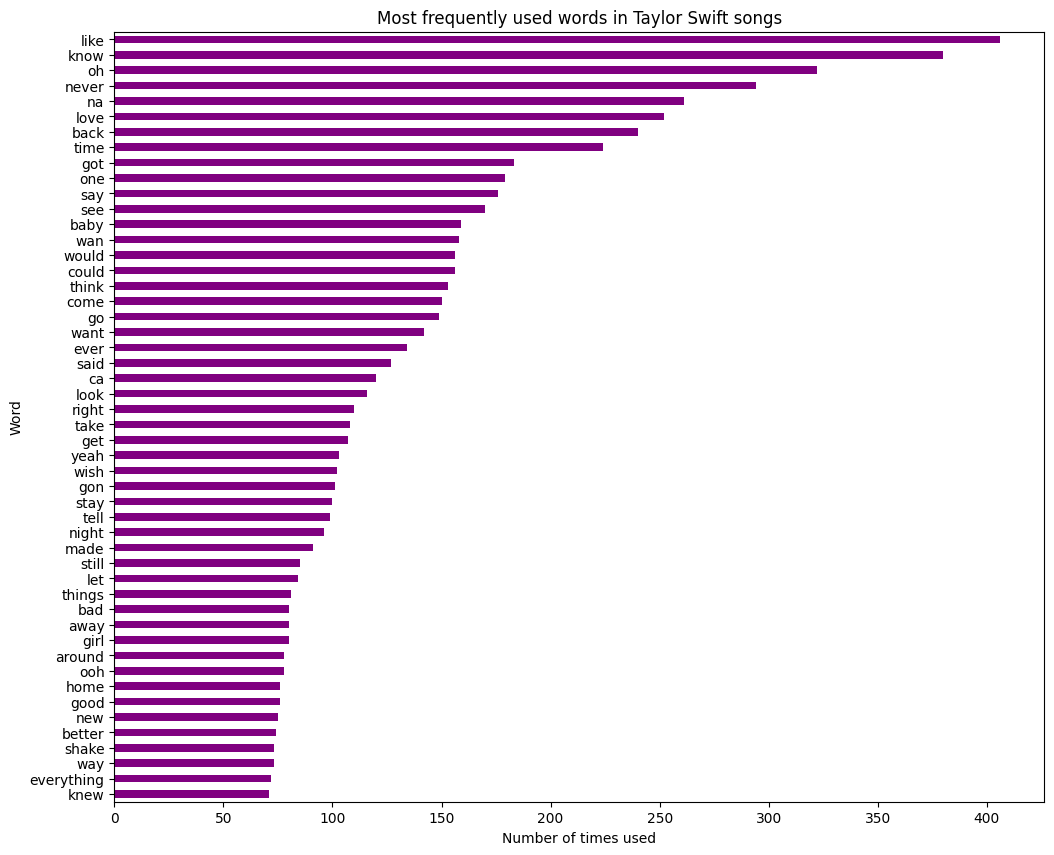

In [4]:
# Ensure NLTK components are available
nltk.download('punkt')
nltk.download('stopwords')

# Reading the data
all_lyrics = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-29/taylor_swift_lyrics.csv')


# Tokenize and clean the data
stop_words = set(stopwords.words('english'))
all_lyrics['tokens'] = all_lyrics['Lyrics'].apply(lambda x: [word.lower() for word in word_tokenize(str(x)) if word.isalpha() and word.lower() not in stop_words])

# Flatten the list of tokens and count word frequencies
all_words = [word for tokens in all_lyrics['tokens'] for word in tokens]
word_freq = pd.Series(all_words).value_counts()

# Display the most popular words
most_popular_words = word_freq.head(50)
print(most_popular_words)

# Create a horizontal bar plot
plt.figure(figsize=(12, 10))
most_popular_words.sort_values().plot(kind='barh', color='purple')
plt.title('Most frequently used words in Taylor Swift songs')
plt.xlabel('Number of times used')
plt.ylabel('Word')
plt.show()

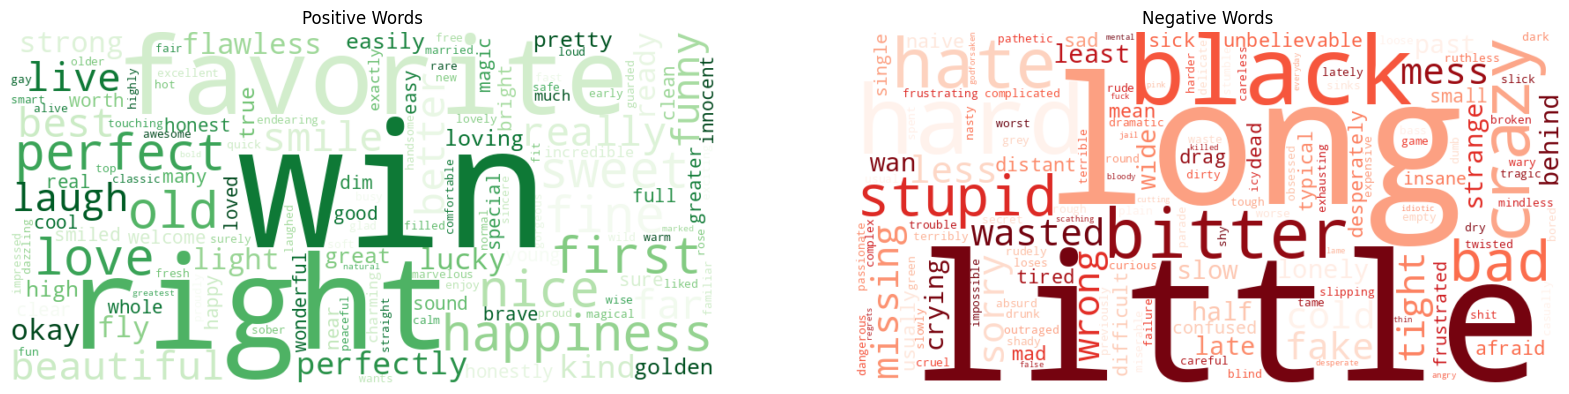

In [5]:
# Define colors (adjust the hex values to your liking or get them from somewhere else)
tswift_colors = {"positive": "#1db954", "negative": "#eb4034"}

# Read the data (we'll just use the previously combined dataframe `all_lyrics`)
# Assuming `all_lyrics` is already defined and contains the combined lyrics data

# Filter out specific words
words_to_filter = ["ooh", "yeah", "ah", "uh", "ha", "whoa", "eh", "hoo", "ey", "mmm", "eeh", "huh", "na"]
all_lyrics['filtered_tokens'] = all_lyrics['tokens'].apply(lambda x: [word for word in x if word not in words_to_filter])

# Flatten the list of tokens and perform sentiment analysis
all_words = [word for tokens in all_lyrics['filtered_tokens'] for word in tokens]
sentiments = {word: TextBlob(word).sentiment.polarity for word in all_words}

# Separate words by sentiment
positive_words = ' '.join([word for word, sentiment in sentiments.items() if sentiment > 0])
negative_words = ' '.join([word for word, sentiment in sentiments.items() if sentiment < 0])

# Generate the word cloud
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_words)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_words)

# Plot the word cloud
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()

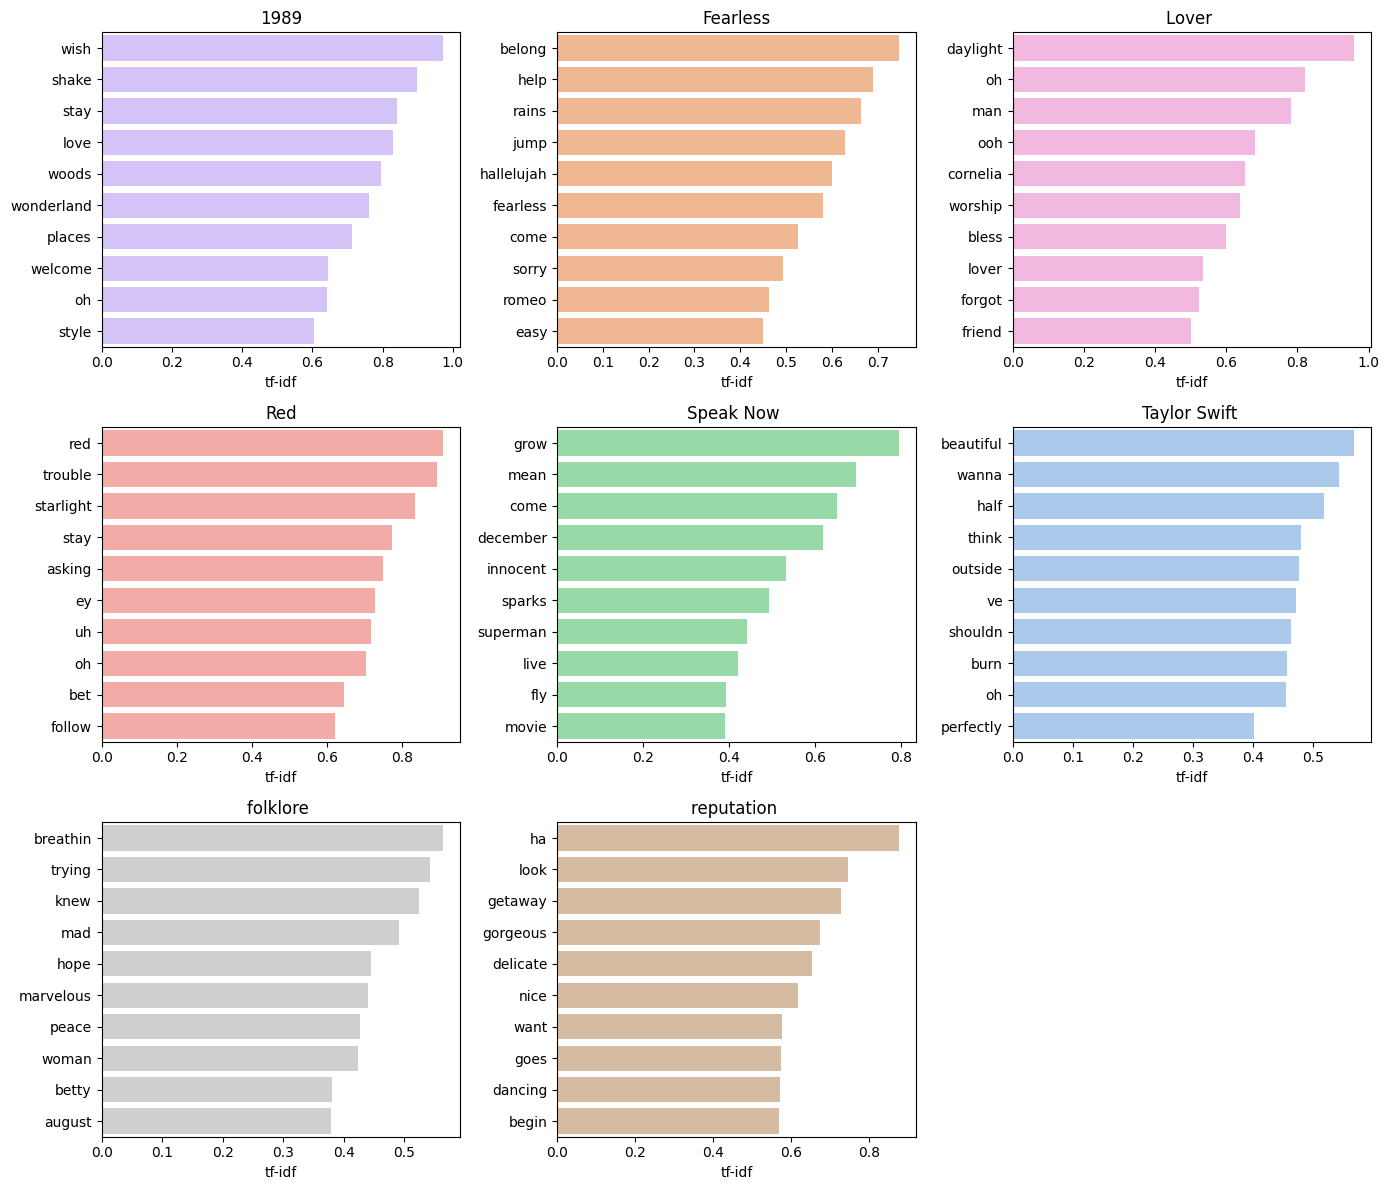

In [6]:
# Initialize the TF-IDF Vectorizer with English stopwords
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(all_lyrics['Lyrics'])

# Create a DataFrame for TF-IDF vectors and add the album names
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=all_lyrics.index, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['Album'] = all_lyrics['Album']

# Calculate the TF-IDF score for each word-album combination
tfidf_df = tfidf_df.melt(id_vars='Album', var_name='Word', value_name='TF-IDF')

# Get the top 10 words for each album based on TF-IDF score
top_tfidf = tfidf_df.groupby('Album').apply(lambda x: x.nlargest(10, 'TF-IDF')).reset_index(drop=True)

# Define color palette for albums
album_colors = sns.color_palette("pastel", len(all_lyrics['Album'].unique()))
color_dict = dict(zip(all_lyrics['Album'].unique(), album_colors))

# Plot setup
albums = top_tfidf['Album'].unique()
n_albums = len(albums)
n_cols = 3  # You can change this to fit your preferred layout
n_rows = n_albums // n_cols + (n_albums % n_cols > 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows), sharex=False, sharey=False)
axes = axes.flatten()

# Plot each album's important words in a separate subplot
for i, album in enumerate(albums):
    ax = axes[i] if n_albums > 1 else axes
    data = top_tfidf[top_tfidf['Album'] == album]
    sns.barplot(x='TF-IDF', y='Word', data=data, ax=ax, color=color_dict[album])
    ax.set_title(album)
    ax.set_xlabel('tf-idf')
    ax.set_ylabel('')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [23]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(all_lyrics['tokens'])
dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=100000)

# Convert dictionary to a bag of words corpus
corpus = [dictionary.doc2bow(text) for text in all_lyrics['tokens']]

# Applying LDA
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=9, passes=10, random_state=42, eval_every=None)
topic_word_distributions = lda_model.get_topics()

# Calculate overall word frequency in the corpus
all_words = [word for tokens in all_lyrics['tokens'] for word in tokens]
corpus_word_frequency = Counter(all_words)
num_docs = len(corpus)

# Initialize dictionaries to hold FREX, Lift, and Highest Probability scores
frex_scores = defaultdict(list)
lift_scores = defaultdict(list)
highest_prob_scores = defaultdict(list)

for topic_id, topic_dist in enumerate(topic_word_distributions):
    for word_id, word_prob in enumerate(topic_dist):
        word = dictionary[word_id]

        # Calculate Lift
        corpus_word_prob = (corpus_word_frequency[word] + 1e-12) / (num_docs + 1e-12)
        lift = word_prob / corpus_word_prob
        lift_scores[topic_id].append((word, lift))

        # Calculate Highest Probability
        highest_prob_scores[topic_id].append((word, word_prob))

# Sorting and displaying top words for each metric
for topic_id in range(lda_model.num_topics):
    # Highest Probability
    sorted_highest_prob = sorted(highest_prob_scores[topic_id], key=lambda x: x[1], reverse=True)[:7]
    highest_prob_words = [word for word, prob in sorted_highest_prob]

    # Lift
    sorted_lifts = sorted(lift_scores[topic_id], key=lambda x: x[1], reverse=True)[:7]
    lift_words = [word for word, lift in sorted_lifts]

    print(f"## Topic {topic_id + 1} Top Words:")
    print(f"## Highest Prob: {highest_prob_words}")
    # FREX would be included here if computed
    print(f"## Lift: {lift_words}\n")

## Topic 1 Top Words:
## Highest Prob: ['wish', 'oh', 'would', 'trouble', 'man', 'right', 'na']
## Lift: ['bother', 'college', 'slipping', 'bills', 'guarded', 'parents', 'forward']

## Topic 2 Top Words:
## Highest Prob: ['na', 'come', 'wan', 'stay', 'shake', 'could', 'ca']
## Lift: ['aside', 'drove', 'finish', 'wishin', 'happen', 'flood', 'lungs']

## Topic 3 Top Words:
## Highest Prob: ['got', 'go', 'oh', 'wonderland', 'tell', 'love', 'come']
## Lift: ['beauty', 'rabbit', 'seemed', 'penny', 'givin', 'opened', 'searched']

## Topic 4 Top Words:
## Highest Prob: ['one', 'oh', 'knew', 'love', 'tell', 'said', 'waiting']
## Lift: ['bleeding', 'bloodstain', 'expired', 'longest', 'sensual', 'downtown', 'stepping']

## Topic 5 Top Words:
## Highest Prob: ['love', 'would', 'made', 'look', 'oh', 'ever', 'one']
## Lift: ['gym', 'intentions', 'homeroom', 'wings', 'assumptions', 'dreamt', 'plus']

## Topic 6 Top Words:
## Highest Prob: ['got', 'knows', 'baby', 'remember', 'love', 'look', 'everybo

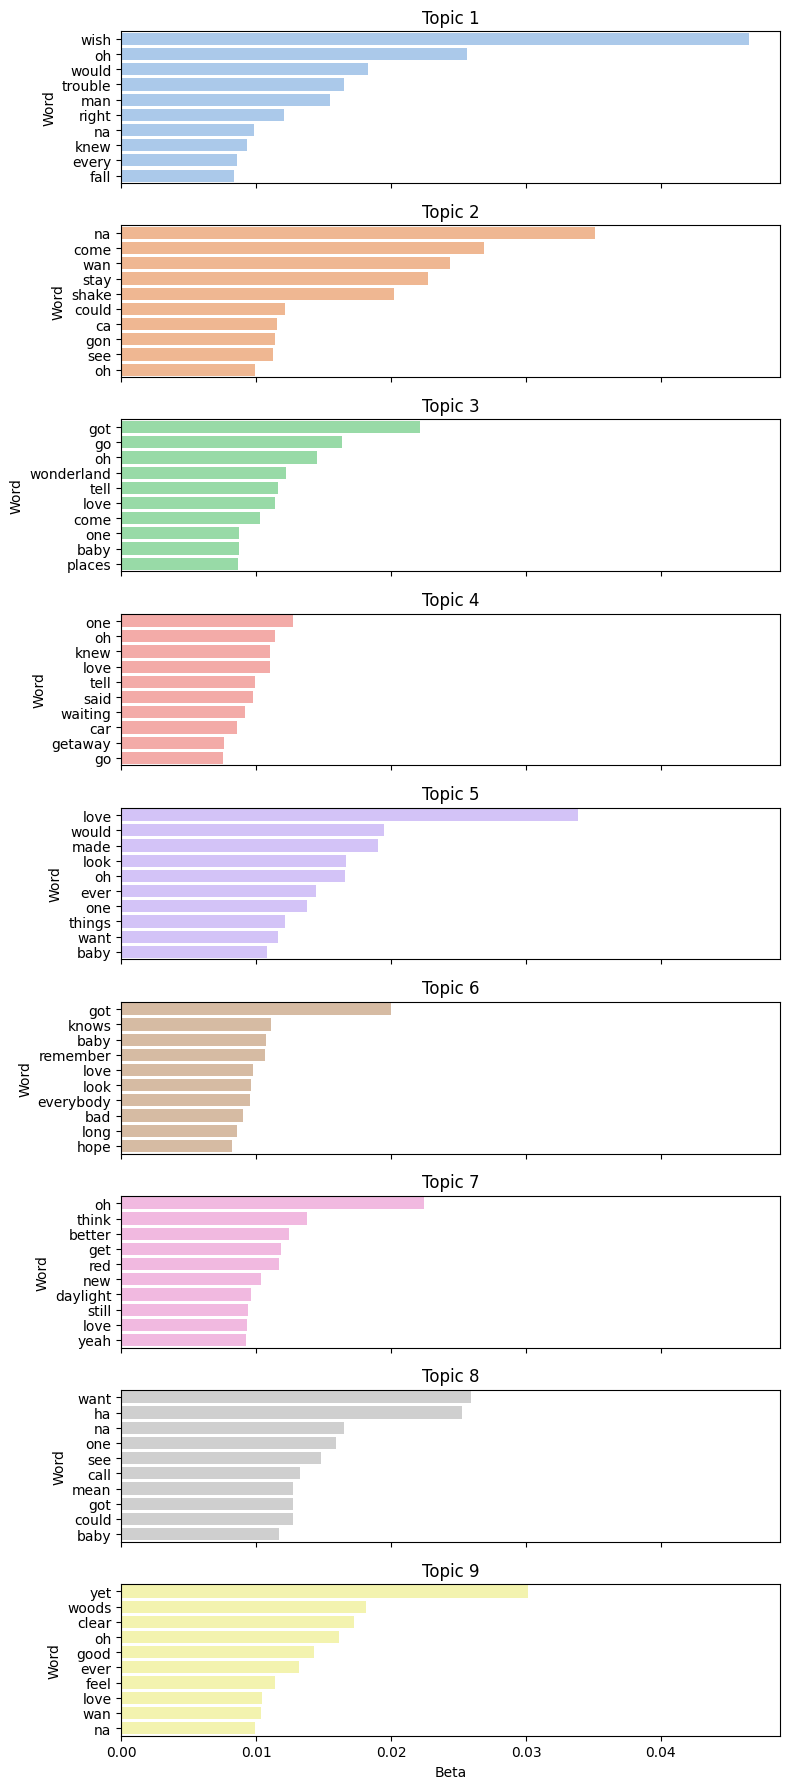

In [33]:
top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, dictionary[word_id], prob)
                                for word_id, prob in lda_model.get_topic_terms(t, topn=10)])

# Convert to DataFrame
top_words_df = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'Beta'])

# Get the unique color for each topic using the pastel palette
topic_colors = sns.color_palette("pastel", n_topics)

# Creating separate subplots for each topic
fig, axes = plt.subplots(n_topics, 1, figsize=(8, 2 * n_topics), sharex=True)

# If there's only one topic, it won't be in an array
if n_topics == 1:
    axes = [axes]

for idx, ax in enumerate(axes):
    # Filter the DataFrame to get the top words for the current topic
    topic_data = top_words_df[top_words_df['Topic'] == idx]
    # Sort the words by their beta values
    topic_data_sorted = topic_data.sort_values('Beta', ascending=False)
    # Create a horizontal bar plot with the specific color for each topic
    sns.barplot(x='Beta', y='Word', data=topic_data_sorted, ax=ax, color=topic_colors[idx])
    ax.set_title(f"Topic {idx + 1}")
    ax.set_xlabel("Beta")

# Adjust layout
plt.tight_layout()
plt.show()

## Emotions in Taylor Swift Songs

<ipython-input-59-fdec5a680293>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Sentiment', data=sentimentscores.sort_values('Score', ascending=False), palette='husl')


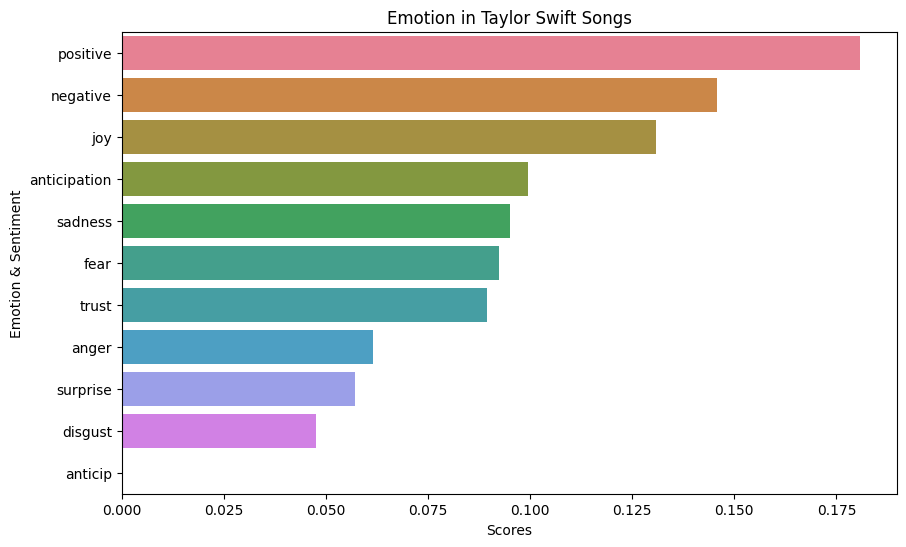

In [59]:
# Flatten the list of tokens into a single list of words
all_words = [word for sublist in all_lyrics['tokens'] for word in sublist]

# Create a single string of words for sentiment analysis
lyrics_str = ' '.join(all_words)

# Perform sentiment analysis using NRCLex
text_object = NRCLex(lyrics_str)

# Calculate sentiment frequency
sentiment_freq = text_object.affect_frequencies

# Convert to DataFrame
sentimentscores = pd.DataFrame(list(sentiment_freq.items()), columns=['Sentiment', 'Score'])

# Plotting the sentiment scores using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Sentiment', data=sentimentscores.sort_values('Score', ascending=False), palette='husl')
plt.title('Emotion in Taylor Swift Songs')
plt.xlabel('Scores')
plt.ylabel('Emotion & Sentiment')
plt.show()


In [64]:
# Filter words associated with "fear"
fear_words = ["bad", "mad", "hate", "feeling", "watch", "lose", "fight", "worship", "afraid", "death", "killing",	"shaking", "dying", "hell", "reckless", "bitch", "danger", "curse"]

# Count the frequency of fear-related words
fear_word_counts = {word: all_words.count(word) for word in fear_words}

# Convert to DataFrame and sort by count
fear_word_counts_df = pd.DataFrame(list(fear_word_counts.items()), columns=['Word', 'Count'])
fear_word_counts_df = fear_word_counts_df.sort_values(by='Count', ascending=False)

# Print the table
print(fear_word_counts_df)


        Word  Count
0        bad     80
1        mad     48
2       hate     44
3    feeling     36
5       lose     28
4      watch     26
6      fight     26
7    worship     10
11   shaking      9
8     afraid      9
10   killing      9
9      death      7
12     dying      6
13      hell      6
14  reckless      6
15     bitch      2
16    danger      2
17     curse      1


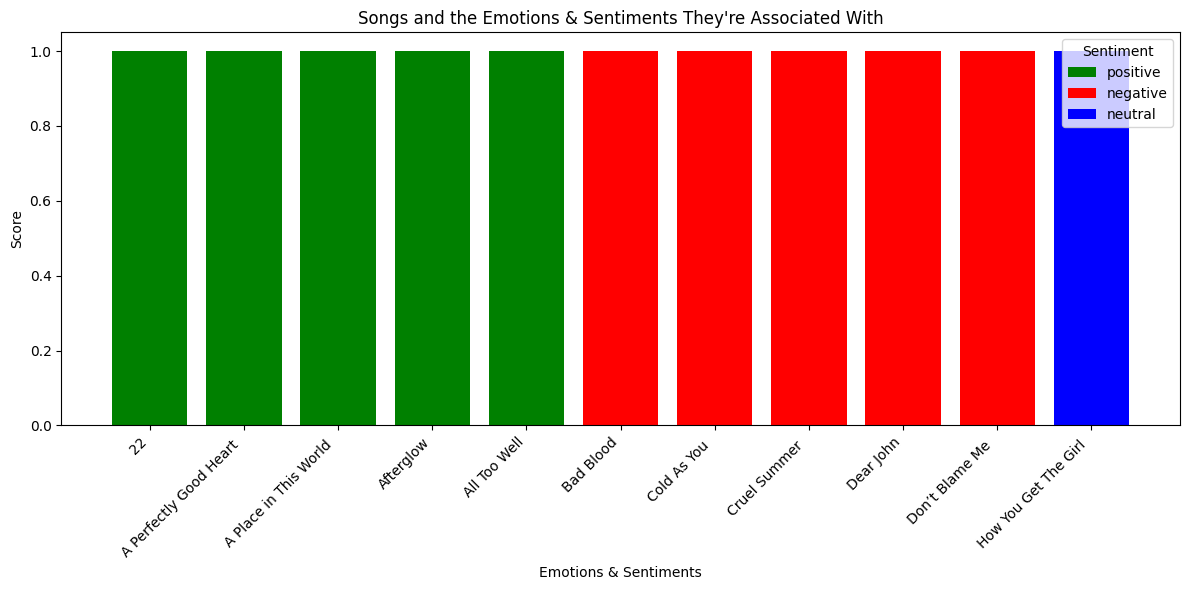

In [90]:
import re
from nltk.sentiment import SentimentIntensityAnalyzer

# Word count
word_count = all_lyrics.groupby('Title ').size().reset_index(name='total_words')

# Join word_count with all_lyrics to get lyric_counts
lyric_counts = all_lyrics.merge(word_count, on='Title ', how='left')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each lyric
lyric_counts['Sentiment_Scores'] = lyric_counts['Lyrics'].apply(lambda x: sid.polarity_scores(x))

# Extract compound sentiment scores
lyric_counts['Compound_Score'] = lyric_counts['Sentiment_Scores'].apply(lambda x: x['compound'])

# Count sentiment occurrences by title
lyric_counts['sentiment'] = lyric_counts['Compound_Score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Count sentiment occurrences by title and sentiment label
sentiment_counts = lyric_counts.groupby(['Title ', 'sentiment']).size().reset_index(name='n')

# Get the top 5 sentiments for each title
top_sentiments = sentiment_counts.groupby('sentiment').apply(lambda x: x.nlargest(5, 'n')).reset_index(drop=True)

# Create a function to abbreviate long titles
def abbreviate_title(title):
    return re.sub(r"(\\w{20}).*", r"\\1.", title)

top_sentiments['Abbreviated_Title'] = top_sentiments['Title '].apply(abbreviate_title)

# Create a bar plot
plt.figure(figsize=(12, 6))
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
for sentiment, color in colors.items():
    data = top_sentiments[top_sentiments['sentiment'] == sentiment]
    plt.bar(data['Abbreviated_Title'], data['n'], color=color, label=sentiment)

plt.xlabel('Emotions & Sentiments')
plt.ylabel('Score')
plt.title("Songs and the Emotions & Sentiments They're Associated With")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()